# Desicion tree classifier of crystal structures, and deep neural network for band gap prediction, in systems with Li content.

# Abstract

Based on chemical and physical features, we deploy a decision tree classifier to predict the crystal system of materials containing Li. The materials are of technological importance because they are used in manufacturing Li-ion batteries. The features we considered are the chemical formula, spacegroup, formation energy, energy above Hull, band gap, number of atoms in the unit cell, density, volume, and whether the Has bandstructure is provided. We use synthetic data to balance the slightly unbalanced data. By using feature engineering, we reduced the number of features to three and were able to obtain a rate of precision of almost 100%. In a more interesting, and challenging, case we design a deep neural network for the prediction of formation energy and band energy. For the former case, we could only achieve a score of 60%.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE # pip3 install imblearn

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from keras.metrics import MeanSquaredError
import chemparse
# """
# chemparse: parsing chemical formula strings into python dictionaries.
# Features
#     Convert a chemical formula string into a python dictionary.
#         example: "CH4" returns {"C":1.0, "H":4.0}
#     Handles fractional stoichiometry.
#         example: "C1.5O3" returns {"C":1.5, "O":3.0}
#         example: "H2e-1O1e-1" returns {"H":0.2, "O":0.1}
#     Handles groups with parentheses.
#         example: "(CH3)2(CH2)4" returns {"C":6.0, "H":14.0}
# """

# Data preprocessing

In [2]:
# panda reading
df = pd.read_csv("lithium_ion.csv")
print(df.columns)
print(df.head(6))
print(df.isnull().sum())
# For each column check the type of variable
df.dtypes

Index(['Materials Id', 'Formula', 'Spacegroup', 'Formation Energy (eV)',
       'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)',
       'Volume', 'Has Bandstructure', 'Crystal System'],
      dtype='object')
  Materials Id       Formula Spacegroup  Formation Energy (eV)  \
0    mp-849394     Li2MnSiO4         Pc                 -2.699   
1    mp-783909     Li2MnSiO4      P21/c                 -2.696   
2    mp-761311    Li4MnSi2O7         Cc                 -2.775   
3    mp-761598  Li4Mn2Si3O10       C2/c                 -2.783   
4    mp-767709  Li2Mn3Si3O10       C2/c                 -2.747   
5    mp-761517    Li4MnSi2O7         C2                 -2.763   

   E Above Hull (eV)  Band Gap (eV)  Nsites  Density (gm/cc)   Volume  \
0              0.006          3.462      16            2.993  178.513   
1              0.008          2.879      32            2.926  365.272   
2              0.012          3.653      28            2.761  301.775   
3              0.01

Materials Id              object
Formula                   object
Spacegroup                object
Formation Energy (eV)    float64
E Above Hull (eV)        float64
Band Gap (eV)            float64
Nsites                     int64
Density (gm/cc)          float64
Volume                   float64
Has Bandstructure           bool
Crystal System            object
dtype: object

In [3]:
# Checking missing values
df.isnull().sum()# Take only categorial values

Materials Id             0
Formula                  0
Spacegroup               0
Formation Energy (eV)    0
E Above Hull (eV)        0
Band Gap (eV)            0
Nsites                   0
Density (gm/cc)          0
Volume                   0
Has Bandstructure        0
Crystal System           0
dtype: int64

In [4]:
print(len(df))

339


# Data exploration

In [5]:
# Group categorial and numerical values.
categ = df.select_dtypes(include=['object','bool']).columns
numer = df.select_dtypes(include=['int64','float64']).columns
print(df[categ].describe())
print()
print(df[numer].describe())

       Materials Id   Formula Spacegroup Has Bandstructure Crystal System
count           339       339        339               339            339
unique          339       114         44                 2              3
top       mp-849394  LiFeSiO4         P1              True     monoclinic
freq              1        42         72               274            139

       Formation Energy (eV)  E Above Hull (eV)  Band Gap (eV)      Nsites  \
count             339.000000         339.000000     339.000000  339.000000   
mean               -2.616950           0.058215       2.079740   38.837758   
std                 0.183809           0.030363       1.087968   23.133142   
min                -2.985000           0.000000       0.000000   10.000000   
25%                -2.757500           0.035500       1.265500   26.000000   
50%                -2.605000           0.062000       2.499000   31.000000   
75%                -2.525500           0.081500       2.968000   52.000000   
max  

In [6]:
# Get different type of structures
df['Crystal System'].unique()

array(['monoclinic', 'orthorhombic', 'triclinic'], dtype=object)

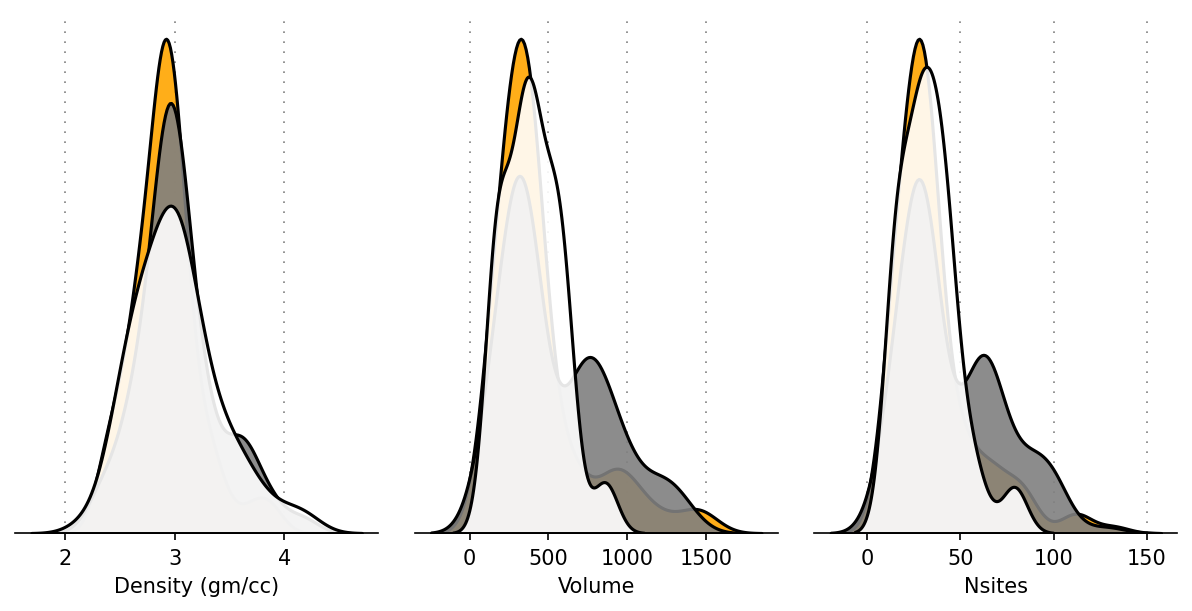

In [7]:
# Plot structural  variables 
features = ['Density (gm/cc)','Volume', 'Nsites' ]

fig = plt.figure(figsize=(10, 11), dpi=150)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.1, hspace=0.4)
background_color = 'white'
    
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax" + str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax" + str(plot)].set_facecolor(background_color)
#           locals()["ax" + str(plot)].tick_params(axis='y', left=False)
        locals()["ax" + str(plot)].get_yaxis().set_visible(False)
        for s in ["top", "right", "left"]:
            locals()["ax" + str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

df_mono = df[df['Crystal System'] == 'monoclinic']
df_ortho = df[df['Crystal System'] == 'orthorhombic']
df_tric = df[df['Crystal System'] == 'triclinic']

for feature in  features:
    sns.kdeplot(df_mono[feature], ax=locals()["ax" + str(plot)], color='orange', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(df_ortho[feature], ax=locals()["ax" + str(plot)], color='gray', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(df_tric[feature], ax=locals()["ax" + str(plot)], color='white', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    locals()["ax" + str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':',                                    dashes=(1, 5))
    locals()["ax"+str(plot)].set_xlabel(feature)
    plot += 1

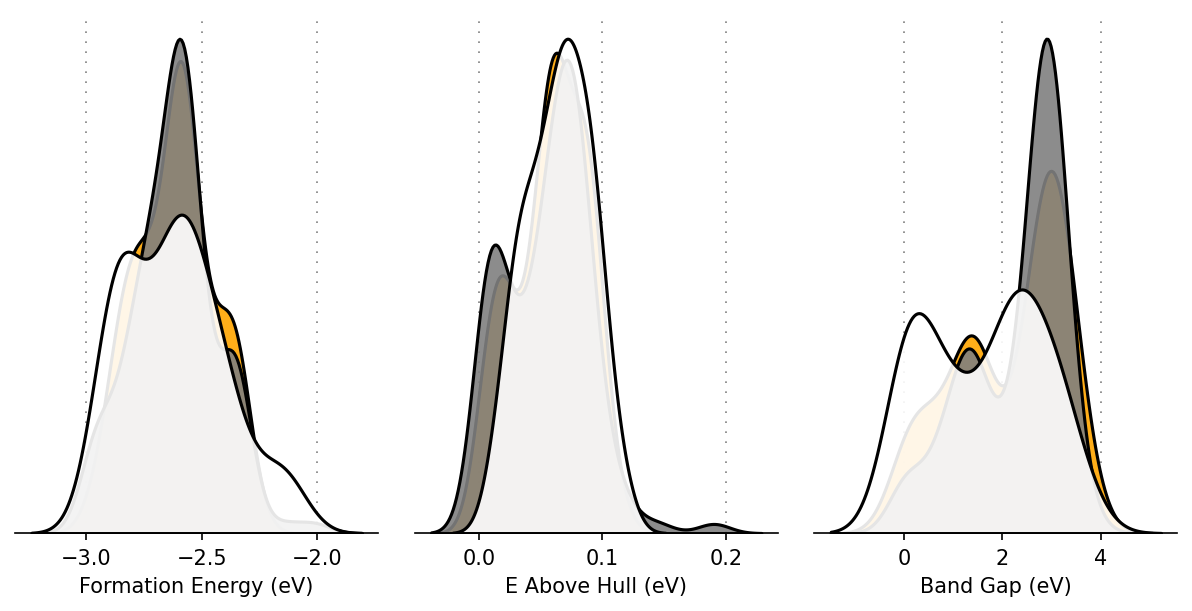

In [8]:
# Plot energy  variables 
features = ['Formation Energy (eV)','E Above Hull (eV)', 'Band Gap (eV)' ]

fig = plt.figure(figsize=(10, 11), dpi=150)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.1, hspace=0.4)
background_color = 'white'
    
plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax" + str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax" + str(plot)].set_facecolor(background_color)
#           locals()["ax" + str(plot)].tick_params(axis='y', left=False)
        locals()["ax" + str(plot)].get_yaxis().set_visible(False)
        for s in ["top", "right", "left"]:
            locals()["ax" + str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

df_mono = df[df['Crystal System'] == 'monoclinic']
df_ortho = df[df['Crystal System'] == 'orthorhombic']
df_tric = df[df['Crystal System'] == 'triclinic']

for feature in  features:
    sns.kdeplot(df_mono[feature], ax=locals()["ax" + str(plot)], color='orange', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(df_ortho[feature], ax=locals()["ax" + str(plot)], color='gray', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    sns.kdeplot(df_tric[feature], ax=locals()["ax" + str(plot)], color='white', shade=True, linewidth=1.5,
                ec='black', alpha=0.9, zorder=3, legend=False)
    locals()["ax" + str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':',                                    dashes=(1, 5))
    locals()["ax"+str(plot)].set_xlabel(feature)
    plot += 1

In [9]:
# We take a look to the space group
print(df['Spacegroup'].nunique())

44


<AxesSubplot:>

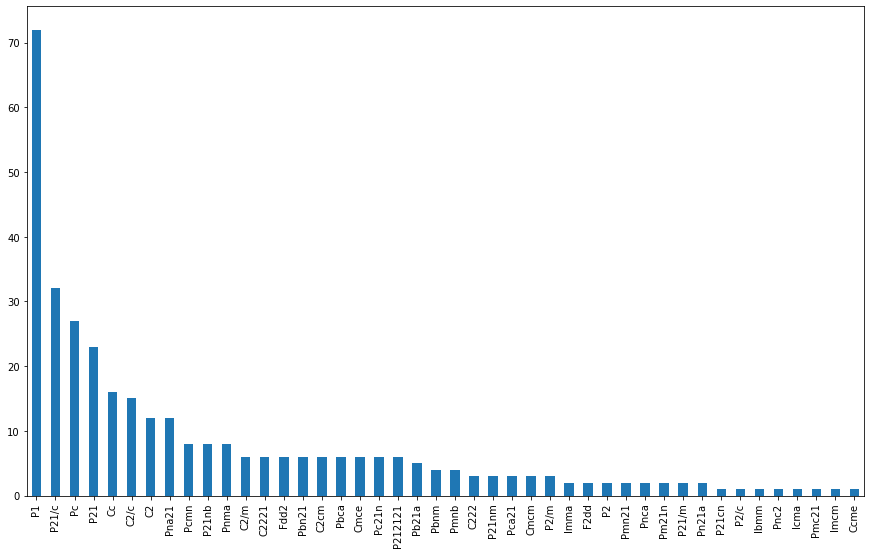

In [10]:
df['Spacegroup'].value_counts().plot(kind='bar', figsize=(15,9))

In [11]:
df['Formula'].unique()
df['Formula'].value_counts()

LiFeSiO4           42
LiCoSiO4           29
Li2FeSiO4          15
Li2CoSiO4          14
Li2MnSiO4          12
                   ..
Li3Co2Si3O10        1
Li10Co(SiO5)2       1
Li4Co2Si3O10        1
Li2FeSi4O11         1
Li5Co4(Si3O10)2     1
Name: Formula, Length: 114, dtype: int64

In [12]:
# We convert  the 44 formulas into a chemical dictionary
# First we use either LabelEncoder or fact
df['Spacegroup_ordinal'] = pd.factorize(df['Spacegroup'])[0]
#df['Spacegroup_ordinal'].value_counts().plot(kind='bar')# Use of chemparse to spli the chemical formula
df['Formula'].value_counts()
decomposed_chemform = df['Formula'].apply(chemparse.parse_formula)
print(decomposed_chemform)

0       {'Li': 2.0, 'Mn': 1.0, 'Si': 1.0, 'O': 4.0}
1       {'Li': 2.0, 'Mn': 1.0, 'Si': 1.0, 'O': 4.0}
2       {'Li': 4.0, 'Mn': 1.0, 'Si': 2.0, 'O': 7.0}
3      {'Li': 4.0, 'Mn': 2.0, 'Si': 3.0, 'O': 10.0}
4      {'Li': 2.0, 'Mn': 3.0, 'Si': 3.0, 'O': 10.0}
                           ...                     
334     {'Li': 6.0, 'Si': 2.0, 'Co': 1.0, 'O': 8.0}
335     {'Li': 1.0, 'Si': 2.0, 'Co': 3.0, 'O': 8.0}
336    {'Li': 5.0, 'Si': 6.0, 'Co': 4.0, 'O': 20.0}
337     {'Li': 1.0, 'Co': 1.0, 'Si': 1.0, 'O': 4.0}
338     {'Li': 3.0, 'Si': 2.0, 'Co': 2.0, 'O': 8.0}
Name: Formula, Length: 339, dtype: object


/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


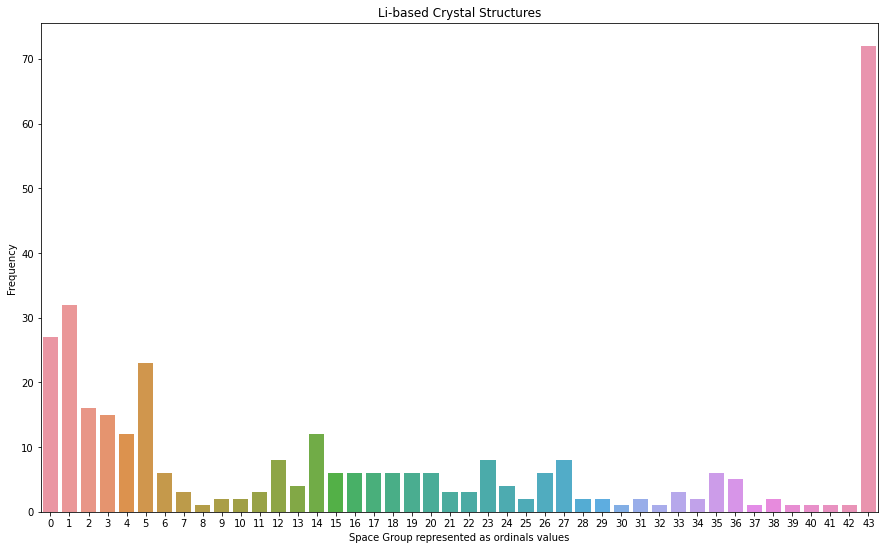

In [13]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.countplot(df['Spacegroup_ordinal'])
plt.title('Li-based Crystal Structures')
plt.xlabel('Space Group represented as ordinals values')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Convert the dictionary into a dataframe and fill NaN's with zero's
# then add new features 'Li', 'Mn','Si', 'O', 'Fe', 'Co'
pd_chemelements = pd.json_normalize(decomposed_chemform)
pd_chemelements = pd_chemelements.fillna(0)
df = df.join(pd_chemelements)
print(df.columns)

Index(['Materials Id', 'Formula', 'Spacegroup', 'Formation Energy (eV)',
       'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)',
       'Volume', 'Has Bandstructure', 'Crystal System', 'Spacegroup_ordinal',
       'Li', 'Mn', 'Si', 'O', 'Fe', 'Co'],
      dtype='object')


In [15]:
# Spcace group

# Ordinal tranformation for the space group
# Two options. With pandas use facotorize, with Sklearn LabelEncpder
df['Spacegroup_ordinal'] = pd.factorize(df['Spacegroup'])[0]
le =LabelEncoder()
df['Spacegroup_ordinal'] = le.fit_transform(df['Spacegroup'])

In [16]:
# Crytal System
# Check data distribution
df['Crystal_System_encoded'] = le.fit_transform(df['Crystal System'])

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


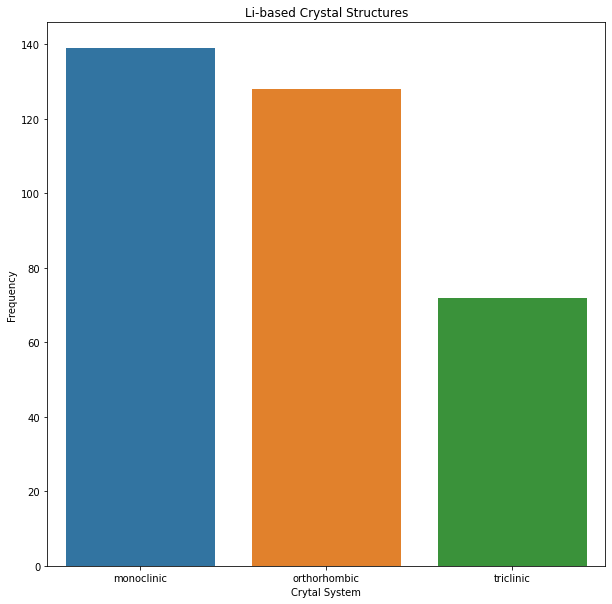

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(df['Crystal System'])
plt.title('Li-based Crystal Structures')
plt.xlabel('Crytal System')
plt.ylabel('Frequency')
plt.show()

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


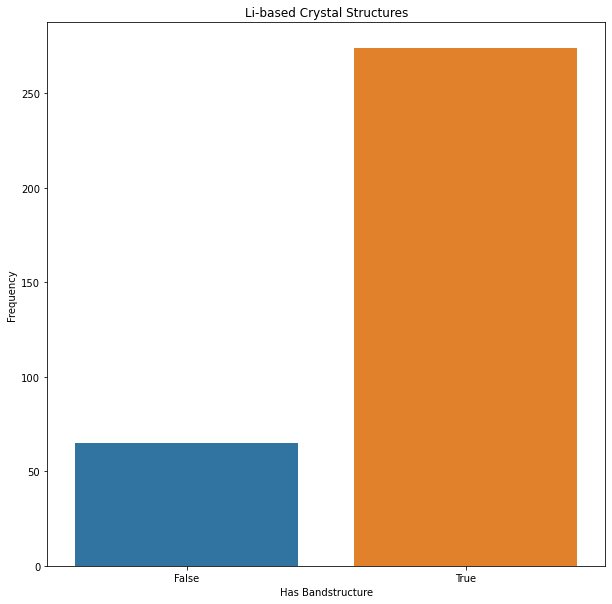

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(df['Has Bandstructure'])
plt.title('Li-based Crystal Structures')
plt.xlabel('Has Bandstructure')
plt.ylabel('Frequency')
plt.show()

In [19]:
features =['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
            'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
            'Spacegroup_ordinal','Li','Mn','Si','O','Fe']

X = df[features]
y = df['Crystal_System_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Data augmentation

In [20]:
sm_sample = SMOTE()
X_train, y_train = sm_sample.fit_resample(X_train, y_train)

/Users/joaquin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


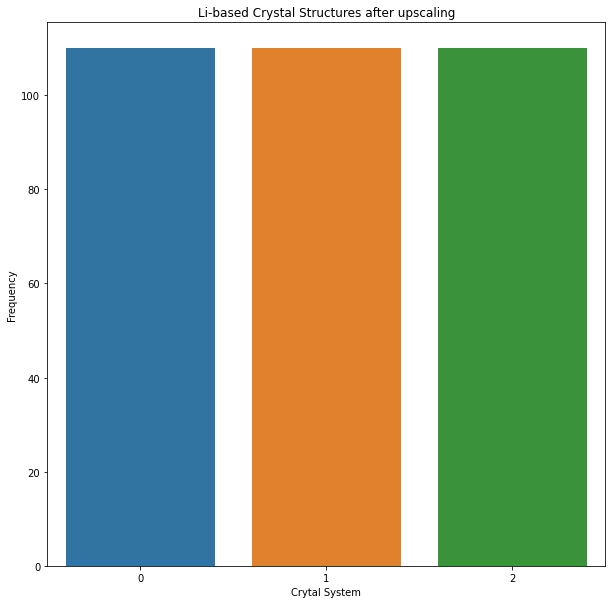

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(y_train)
plt.title('Li-based Crystal Structures after upscaling')
plt.xlabel('Crytal System')
plt.ylabel('Frequency')
plt.show()

# Modeling with Decision Tree Classifier

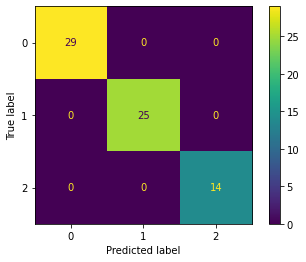

In [22]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

cm = confusion_matrix(y_test,y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

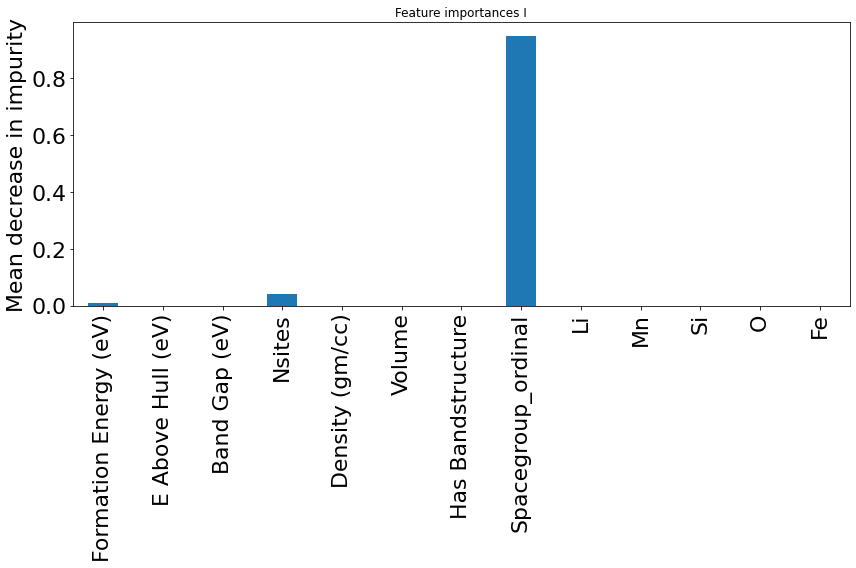

In [23]:
features = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
            'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
            'Spacegroup_ordinal','Li','Mn','Si','O','Fe']


importances = model.feature_importances_
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.bar(ax=ax)  # , yerr=std
#title = "Feature importances using MDI for "+ m
ax.set_title("Feature importances I")
ax.set_ylabel("Mean decrease in impurity", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
fig.tight_layout()
#svp = 'importfeat' + m + '.png'
plt.show()

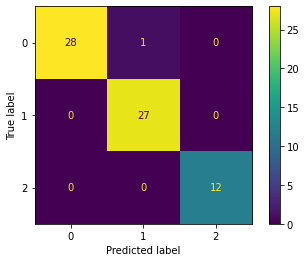

In [38]:
features_reddim =[ 'Nsites', 'Spacegroup_ordinal','Li','Mn','Si','O','Fe']

X2 = df[features_reddim]
y2 = df['Crystal_System_encoded']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.8)


sm_sample = SMOTE()
X2_train, y2_train = sm_sample.fit_resample(X2_train, y2_train)

model = DecisionTreeClassifier()
model.fit(X2_train,y2_train)
y2_predict = model.predict(X2_test)

cm = confusion_matrix(y2_test,y2_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

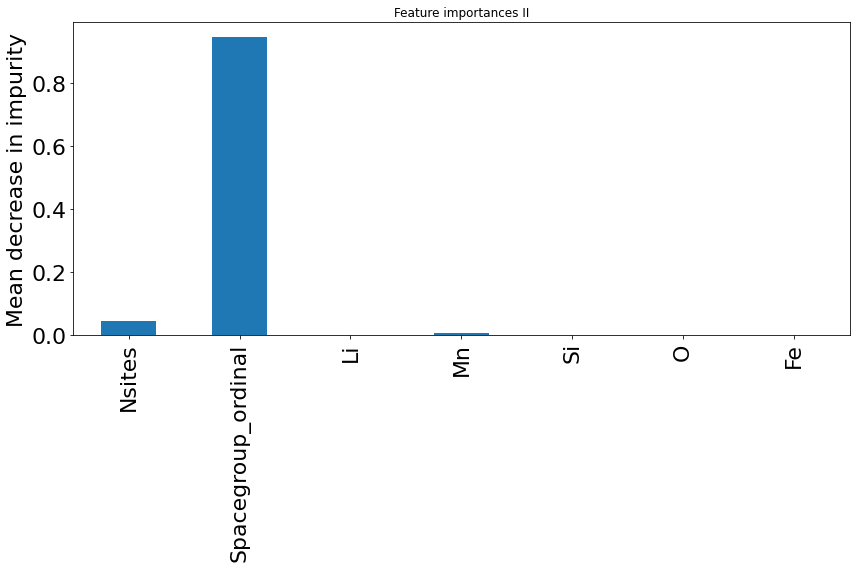

In [39]:

importances = model.feature_importances_
forest_importances = pd.Series(importances, index=features_reddim)
fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.bar(ax=ax)  # , yerr=std
#title = "Feature importances using MDI for "+ m
ax.set_title("Feature importances II")
ax.set_ylabel("Mean decrease in impurity", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
fig.tight_layout()
#svp = 'importfeat' + m + '.png'
plt.show()

# Conclusions I
The reduced dimensionality suggests that some features might be directly related to others. For instance, the density and the volume, while the number of the site are of greater importance. The space group is clearly a leading factor. Atoms seem to play a minor role, however, their key role might be overshadowed by the space group which is selected by the atomic composition.


# Deep Neural Network (Band Gap)

In [26]:
features2 =['Crystal_System_encoded', 'Formation Energy (eV)', 'E Above Hull (eV)',
            'Nsites','Density (gm/cc)','Volume',
            'Spacegroup_ordinal','Li','Mn','Si','O','Fe',]


X = df[features2]
X = np.asarray(X)
y = df['Band Gap (eV)']
# y = np.reshape(y, (-1,1)
#X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X)

[[ 0.000e+00 -2.699e+00  6.000e-03 ...  1.000e+00  4.000e+00  0.000e+00]
 [ 0.000e+00 -2.696e+00  8.000e-03 ...  1.000e+00  4.000e+00  0.000e+00]
 [ 0.000e+00 -2.775e+00  1.200e-02 ...  2.000e+00  7.000e+00  0.000e+00]
 ...
 [ 2.000e+00 -2.529e+00  8.200e-02 ...  6.000e+00  2.000e+01  0.000e+00]
 [ 2.000e+00 -2.348e+00  8.700e-02 ...  1.000e+00  4.000e+00  0.000e+00]
 [ 2.000e+00 -2.406e+00  9.000e-02 ...  2.000e+00  8.000e+00  0.000e+00]]


In [27]:
print(X_train)
print(y_train)

[[ 0.    -2.66   0.044 ...  1.     4.     0.   ]
 [ 0.    -2.607  0.087 ...  2.     8.     0.   ]
 [ 1.    -2.574  0.094 ...  3.     9.     0.   ]
 ...
 [ 1.    -2.598  0.094 ...  2.     8.     1.   ]
 [ 1.    -2.353  0.082 ...  1.     4.     0.   ]
 [ 1.    -2.598  0.023 ...  1.     4.     1.   ]]
10     2.785
27     0.370
262    2.842
267    0.904
221    2.700
       ...  
106    2.825
222    3.087
231    2.082
257    1.411
188    2.959
Name: Band Gap (eV), Length: 271, dtype: float64


# Model

We present the best architecture among, the ones we tested, that achieved the highest score. The resulting neural network is composed of seven layers with "relu" activation functions. We intercalate layers containing dropout, ridge, and lasso regularizers. In addition, we tune batch sizes and early stops to avoid overfitting and get the higher scores in the validation data.

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='relu' ))
model.add(keras.layers.Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(keras.layers.Dense(40, activation='relu', kernel_regularizer=keras.regularizers.l1(l=0.15)))
model.add(keras.layers.Dense(10, activation='relu'))
# Output layer for binary classification
model.add(keras.layers.Dense(1, activation='linear'))
#kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)

2022-06-24 19:02:44.806388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
def r2_score(y_true, y_pred):
    y_diff = tf.reduce_sum(tf.square(y_true-y_pred))
    y_square = tf.reduce_sum(tf.square(y_true-tf.reduce_mean(y_true)))
    return 1-y_diff/y_square

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=tfa.metrics.RSquare() ) 
#  metrics= ['MeanSquaredError']
# metrics=tfa.metrics.RSquare()

In [31]:
# Use callback to stop the trainning after recall does not improve after 20 epochs
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=110, mode="auto")

In [32]:
history = model.fit(X_train, y_train, batch_size=80,
                    epochs=8100, verbose=False,
                    validation_data=(X_test, y_test),
                    callbacks=[callback]
                    )
print(history.history.keys())

dict_keys(['loss', 'r_square', 'val_loss', 'val_r_square'])


In [33]:
# test the model

mse = MeanSquaredError()

y_pred_train = model.predict(X_train, verbose=False)
mse.update_state(y_train, y_pred_train)
print('MSE of train data:', mse.result().numpy())
y_pred_test = model.predict(X_test, verbose=False)
mse.update_state(y_test, y_pred_test)
print('MSE of test data:', mse.result().numpy())

MSE of train data: 0.57578826
MSE of test data: 0.6046468


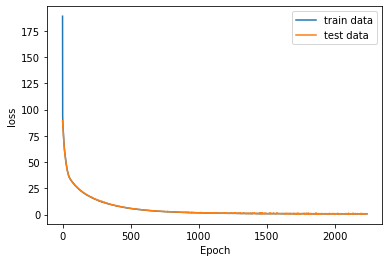

In [34]:
#  Plot of  loss to see how early stop voids overfitting 
# and chose best score for train and test data.

plt.plot(history.history['loss'], label='train data')
plt.plot(history.history['val_loss'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

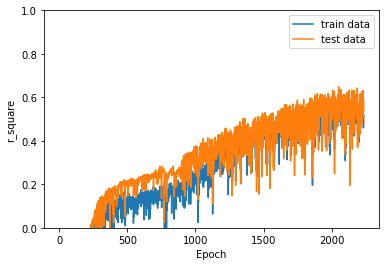

In [35]:
#  Plot of  r_squared to see how early stop voids overfitting 
# and chose best score for train and test data.

plt.plot(history.history['r_square'], label='train data')
plt.plot(history.history['val_r_square'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('r_square')
plt.ylim([0,1])
plt.legend()
plt.show()

In [36]:
# #  Plot of  r2_score to see how early stop voids overfitting 
# # and chose best score for train and test data.

# plt.plot(history.history['r2_score'], label='Train data')
# plt.plot(history.history['val_r2_score'], label='Test data')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.show()

#print('R2 of train data:', r2_score(y_train, y_pred_train))
#print('R2 of test data:', r2_score(y_test, y_pred_test))

# Conclusions II
The 60 % score on the test, and also train data, show that the model is not accurate enough. In contrast to the prediction of the crystal structure, the prediction of the gap energy turned out to be much more challenging. We believe that a deep neural network is a good option and it just needs to be fine-tuned. In this regard, a grid search might provide an optimal set of hyperparameters.
